In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
df = pd.read_csv(r'.\data\train.csv')
df.head()

,review,sentiment
0,Randolph Scott is heading into Albuquerque to ...,positive
1,I like this movie cause it has a good approach...,positive
2,Well don't expect anything deep an meaningful....,positive
3,"This really should deserve a ""O"" rating, or ev...",negative
4,Dwight Frye steals the show in this one as a f...,positive


In [3]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [4]:
X = df['review']
y = df['sentiment']

In [5]:
y = np.where(y=='positive',1,0)

In [12]:
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
ps = PorterStemmer()
nltk.download('stopwords')
def text_preprocessing(reviews):
    corpus = []
    for doc in tqdm(reviews):
        review = re.sub(r'[^a-zA-Z]',' ',doc)
        review = re.sub(r'br','',review)
        review = review.lower()
        review = review.split()
        
        review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
        # print(review)
        corpus.append(" ".join(review))
    return corpus

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rawat\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [15]:
X = text_preprocessing(X)

100%|██████████| 33500/33500 [19:23<00:00, 28.80it/s]


In [6]:
X = pd.read_csv('artifect/X_train_processed.csv')
X.head()

,0
0,randolph scott head albuquerqu take job uncl h...
1,like movi caus good approach buddhism exampl w...
2,well expect anyth deep meaning fight scene pre...
3,realli deserv rate even neg ten watch show age...
4,dwight frye steal show one foolish young man s...


In [7]:
X = X['0']

In [8]:
from tensorflow.keras.preprocessing.text import one_hot

In [9]:
vocab_size = 20000

In [10]:
one_hot_rep = [one_hot(word,vocab_size) for word in X]

In [22]:
# one_hot_rep

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
max([len(sent) for sent in one_hot_rep])

1417

In [13]:
sent_length =1500
embedded_docs = pad_sequences(one_hot_rep,padding='pre',maxlen=sent_length)
embedded_docs

array([[    0,     0,     0, ...,  2097, 13234, 13254],
       [    0,     0,     0, ...,  4195, 10102, 12251],
       [    0,     0,     0, ..., 15325,  7518, 19181],
       ...,
       [    0,     0,     0, ...,  4734,  7631,   838],
       [    0,     0,     0, ..., 10846,  6339,  9340],
       [    0,     0,     0, ..., 10929,  9906, 12352]])

In [14]:
embedded_docs.shape

(33500, 1500)

In [15]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional


In [16]:
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 40)          800000    
                                                                 
 bidirectional (Bidirection  (None, 200)               112800    
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 913001 (3.48 MB)
Trainable params: 913001 (3.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embedded_docs, y, test_size=0.33, random_state=42)

In [18]:
## Model Training
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=32)

Epoch 1/5


702/702 [==============================] - 845s 1s/step - loss: 0.4123 - accuracy: 0.8116 - val_loss: 0.3130 - val_accuracy: 0.8693
Epoch 2/5
702/702 [==============================] - 725s 1s/step - loss: 0.2447 - accuracy: 0.9052 - val_loss: 0.3331 - val_accuracy: 0.8705
Epoch 3/5
702/702 [==============================] - 758s 1s/step - loss: 0.1695 - accuracy: 0.9378 - val_loss: 0.4306 - val_accuracy: 0.8557
Epoch 4/5
702/702 [==============================] - 784s 1s/step - loss: 0.1302 - accuracy: 0.9544 - val_loss: 0.4091 - val_accuracy: 0.8497
Epoch 5/5
702/702 [==============================] - 801s 1s/step - loss: 0.0966 - accuracy: 0.9677 - val_loss: 0.5524 - val_accuracy: 0.8532


In [22]:
import pickle

In [24]:
with open('model_1.pkl','wb') as f:
    pickle.dump(model,f)

In [25]:
y_pred = model.predict(X_test)


346/346 [==============================] - 82s 235ms/step


In [27]:
y_pred = np.where(y_pred>.5,1,0)

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [28]:
accuracy_score(y_pred,y_test)

0.8531886024423337

In [32]:
confusion_matrix(y_pred,y_test)

array([[4475,  553],
       [1070, 4957]], dtype=int64)

In [30]:
import matplotlib.pyplot as plt

def plot_model_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Assuming you have a variable named 'history' containing the training history
# of your model. You can pass it to the function like this:
# plot_model_history(history)


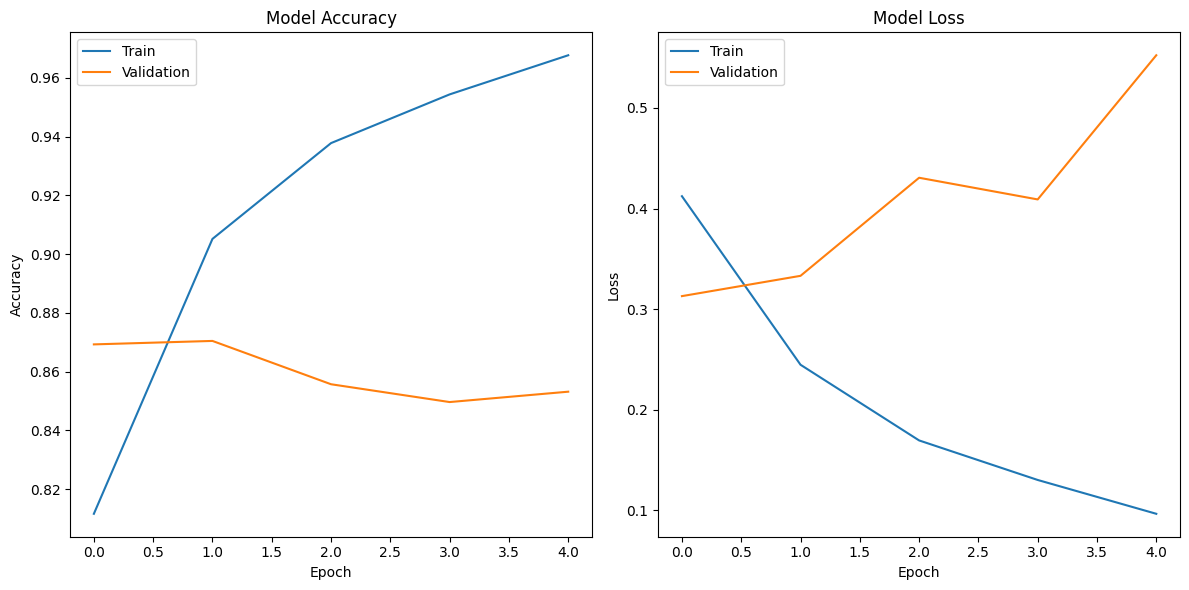

In [31]:
plot_model_history(history)

In [36]:
test = pd.read_csv('X_test_processed.csv')
test_x = test['0']
# test.head()

In [40]:
test_y = pd.read_csv('data/test.csv')
test_y = test_y['sentiment']
# test_y = np.where('positive',1,0)

In [41]:
test_y.head()

0    positive
1    positive
2    negative
3    positive
4    negative
Name: sentiment, dtype: object

In [43]:
test_y.unique()

array(['positive', 'negative'], dtype=object)

In [44]:
test_y = np.where(test_y=='positive',1,0)

In [45]:
one_hot_rep = [one_hot(word,vocab_size) for word in test_x]

In [46]:
sent_length =1500
embedded_docs = pad_sequences(one_hot_rep,padding='pre',maxlen=sent_length)
embedded_docs

array([[    0,     0,     0, ..., 10398,  9712,  1528],
       [    0,     0,     0, ...,  9726, 11147,  7521],
       [    0,     0,     0, ..., 19155,  3708,  2027],
       ...,
       [    0,     0,     0, ...,  2144,  7514,  8847],
       [    0,     0,     0, ...,  2779,  6909,  8847],
       [    0,     0,     0, ..., 19940, 15159,  3242]])

In [47]:
y_pred = model.predict(embedded_docs)

516/516 [==============================] - 104s 201ms/step


In [48]:
y_pred = np.where(y_pred>.5,1,0)

In [49]:
accuracy_score(y_pred,test_y)

0.8535757575757575